## EFRCourierOpenLoop Report


In [341]:
import cmlreaders as cml
import matplotlib.pyplot as plt
# from ptsa.data.filters import ButterworthFilter
# from ptsa.data.filters import MorletWaveletFilter
# import xarray as xr
import warnings; warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
from eeg_check import eeg_check,plot_eeg_check_jlab,erp_sme

In [342]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_to_pybeh as pb
from pandas_to_pybeh import *
import seaborn as sns
import os,sys,argparse,glob

import json
from  matplotlib.ticker import FuncFormatter

pd.set_option('display.max_columns', 1000)
import warnings
warnings.filterwarnings("ignore")

In [343]:
# add 'phase' column to events df (with 'encoding', 'retrieval' for FR, FFR (final FR) or FSR (final store recall))
def add_phase(evs):
    new_evs = pd.DataFrame([])
    for ind,list_evs in evs.groupby('trial'): # 'trial' is the aquivalent of a delivery day
        if list_evs['trial'].unique()!=-999:
            list_evs['phase']='nan'

            # find indexes of encoding start and end
            first_pointing_index = min(list_evs[list_evs['type']=='pointing begins'].index)
            navigation_end_index = min(list_evs[list_evs['type']=='TRIAL_END'].index)-1
            list_evs.loc[first_pointing_index:navigation_end_index]['phase']='encoding'

            # find indexes of retrieval start and end
            rec_start_index = list_evs[list_evs['type']=='REC_START'].index[0]
            rec_end_index = list_evs[list_evs['type']=='REC_STOP'].index[0]
            list_evs.loc[rec_start_index:rec_end_index]['phase']='retrieval'

            if len(list_evs[list_evs.type=='FSR_START'])>0: # relevant only for the final trial
                # find indexes of Final FR for stores start and end
                FSR_start_index = list_evs[list_evs['type']=='FSR_START'].index[0]
                FSR_end_index = list_evs[list_evs['type']=='FSR_STOP'].index[0]
                list_evs.loc[FSR_start_index:FSR_end_index]['phase']='FSR'

                 # find indexes of Final FR for items start and end
                FFR_start_index = list_evs[list_evs['type']=='FFR_START'].index[0]
                FFR_end_index = list_evs[list_evs['type']=='FFR_STOP'].index[0]
                list_evs.loc[FFR_start_index:FFR_end_index]['phase']='FFR'

        elif list_evs['trial'].unique()==-999:
            list_evs['phase']='nan'
            

        new_evs=pd.concat([new_evs,list_evs])

    return new_evs



In [345]:
whole_df = cml.CMLReader.get_data_index() 
sub_df_exp = 'EFRCourierReadOnly'#'EFRCourierOpenLoop'
sub_df = whole_df.query('experiment == @sub_df_exp')
# sub_df


In [347]:
whole_df = cml.CMLReader.get_data_index() 
sub_df_exp = 'EFRCourierReadOnly'#'EFRCourierOpenLoop'
sub_df_subject = 'R1642J'# 'R1620J' # R1637T
sub_df_session=2
sub_df = whole_df.query('experiment == @sub_df_exp and subject == @sub_df_subject and session == @sub_df_session')

# sub_df_subject = sub_df.iloc[0]['subject']
# sub_df_exp = sub_df.iloc[0]['experiment']
# sub_df_session = sub_df.iloc[0]['session']
# sub_df

In [348]:
print(sub_df_subject+' subject, ' +sub_df_exp+ ' session '+str(sub_df_session))


R1642J subject, EFRCourierReadOnly session 2


In [349]:
reader = cml.CMLReader(subject=sub_df_subject, experiment=sub_df_exp, session=sub_df_session)
evs = reader.load('task_events')
evs.head(6)
full_evs = add_phase(evs)
# evs.phase.unique()

# Behavioural Data

## Navigation 

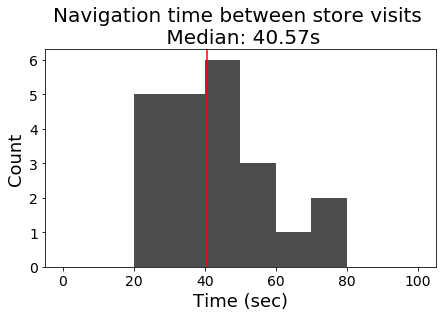

In [350]:
word_evs = full_evs.query('type == "WORD"')
total_delivery_time = []

for trial, trial_evs in word_evs.groupby("trial"):
    delivery_times = np.diff(trial_evs.mstime) / 1000
    total_delivery_time.extend(delivery_times)

median = np.median(total_delivery_time)
median = float("{0:.2f}".format(median))
fig, ax = plt.subplots(figsize=(7,4))
plt.hist(total_delivery_time, color=(0.3,0.3,0.3), range=(0, 100))
plt.axvline(np.median(total_delivery_time), color="r")
plt.title("Navigation time between store visits \n Median: {}s".format(median), fontsize=20)
plt.xlabel("Time (sec)", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# make ticks larger
plt.show()

Histogram of navigation time between each two stores in town.

Prior data shows that in 80% of trials patient reach the next store within 50 sec.
Too long navigation times may indicate that patients paused playing the game or did not understand the instructions.

# Pointing task 


In [351]:
def circular_hist(ax, x, bins=16, density=True, offset=0, gaps=True):
    """
    Produce a circular histogram of angles on ax.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    # Wrap angles to [-pi, pi)
    x = (x+np.pi) % (2*np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        bins = np.linspace(-np.pi, np.pi, num=bins+1)

    # Bin data and record counts
    n, bins = np.histogram(x, bins=bins)

    # Compute width of each bin
    widths = np.pi/18

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area/np.pi) ** .5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n

    # Plot data on ax
    patches = ax.bar(bins[:-1], radius, zorder=1, align='edge', width=widths,
                     edgecolor='C0', fill=True, linewidth=1)

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

    return n, bins, patches

In [353]:
pointing_evs = full_evs[full_evs.type == 'pointing finished']
# pointing_evs

In [354]:
pointing_evs = full_evs[full_evs.type == 'pointing finished']
filt_point_evs = pointing_evs[(pointing_evs['storeX']) != -999.00]
# print(len(pointing_evs))
# print(len(filt_point_evs))

#find the raw pointing error for each pointing task completed
submitted_point = filt_point_evs['submittedPointingDirection'] 
correct_point = filt_point_evs['correctPointingDirection']
difference = np.radians(submitted_point - correct_point)
difference = (difference + np.pi) % (2 * np.pi) - np.pi
difference = np.array(difference)

#find the store locations for all stores visited 
store_evs = full_evs[~pd.isnull(full_evs['storeX'])]
store_evs = store_evs[~pd.isnull(store_evs['store'])]
stores = store_evs.groupby('store')  
stores = stores.agg('mean')[['storeX', 'storeZ']]
storeX = stores['storeX'].values
storeZ = stores['storeZ'].values

pos_angles = []
correct_point = np.array(correct_point)
x = 0
for i, finished_row in filt_point_evs.iterrows():
    position_x, position_z = finished_row[['presX', 'presZ']]
    difference_x = (storeX - position_x)
    difference_z = (storeZ - position_z)
    angle = np.arctan2(difference_z, difference_x) 
    angle = (angle + np.pi) % (2 * np.pi) - np.pi
    angle = np.abs(angle)
    pos_angles.append(np.median(angle - correct_point[x]))
    x = x + 1

# apply correction of pointing error and wrap again to display nicely
pos_angles = np.array(pos_angles)
pos_angles = np.radians(pos_angles)
point_error = difference/ pos_angles
point_error = (point_error + np.pi) % (2 * np.pi) - np.pi


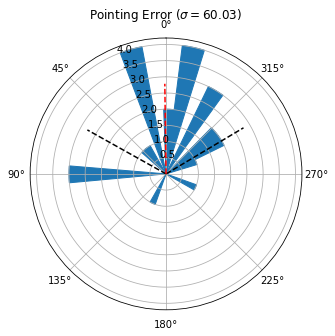

In [355]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm
import statistics

plt.figure(figsize=(5,5))
ax = plt.subplot(111, projection = 'polar')

n, bins, _ = circular_hist(ax, point_error, offset = np.pi/2, bins = 30, density = False)
plt.title('Pointing Error ($\sigma = {:.2f}$)'.format(point_error.std()*180/np.pi))
ax.vlines([np.mean(point_error)+point_error.std(), np.mean(point_error)-point_error.std()], ymin = 0, 
          ymax = np.max(point_error.size/np.pi)*0.35, ls = "--", colors = 'k')
ax.vlines(np.mean(point_error), ymin = 0, ymax=np.max(point_error.size/np.pi)*0.35,ls = '--', colors = 'r')
plt.show()


In [356]:
# this code should be adjusted - generalize beyond i-2...
correct_recall=[]
wrong_recall=[]
for ind,row in full_evs.iterrows():
    if row['type']== 'CUED_REC_WORD' and full_evs.loc[ind-1]['type']=='CUED_REC_CUE':
        if row['item'] == full_evs.loc[ind-1]['item']:
                correct_recall.append(ind)
        elif row['item'] != full_evs.loc[ind-1]['item']:
                wrong_recall.append(ind)
    if row['type']== 'CUED_REC_WORD' and full_evs.loc[ind-1]['type']=='CUED_REC_WORD_VV':
        if row['item'] == full_evs.loc[ind-2]['item']:
                correct_recall.append(ind)
        elif row['item'] != full_evs.loc[ind-1]['item']:
                wrong_recall.append(ind)


In [357]:
# check
full_evs.loc[correct_recall , 'recalled'] = 1
full_evs.loc[wrong_recall , 'recalled'] = 0
# full_evs[full_evs.isin(['CUED_REC_WORD','CUED_REC_CUE'])]
# full_evs[full_evs.type.isin(['CUED_REC_WORD','CUED_REC_CUE'])].head(10)

In [358]:
correct_recall=[]
wrong_recall=[]
for ind,row in full_evs.iterrows():
    if row['type']== 'FFR_REC_WORD':
#         print(row['item'])
        if row['item'] in list(full_evs[full_evs.type=='WORD']['item']):
            correct_recall.append(ind)
        else:
            wrong_recall.append(ind)

# correct_recall

In [359]:
# check
full_evs.loc[correct_recall , 'recalled'] = 1
full_evs.loc[wrong_recall , 'recalled'] = 0
# full_evs[full_evs.isin(['CUED_REC_WORD','CUED_REC_CUE'])]
# full_evs[full_evs.type.isin(['FFR_REC_WORD'])].head(10)

In [360]:
# mean number of correct recalls
for i,row in full_evs.query('type == "WORD"').groupby(["subject", "session"]):
    mean_recalled=np.mean(row['recalled'])
# mean number of correct cued recalls
for i,row in full_evs.query('type == "CUED_REC_WORD"').groupby(["subject", "session"]):
    mean_cued_recalled=np.mean(row['recalled'])
# mean number of correct final store recalls
for i,row in full_evs.query('type == "SR_REC_WORD"').groupby(["subject", "session"]):
    correct_store_mean = len(row[row['intrusion']==0])/len(row)
# mean number of correct final items recalls
for i,row in full_evs.query('type == "FFR_REC_WORD"').groupby(["subject", "session"]):
    correct_item_mean = np.sum(row['recalled'])/len(row)


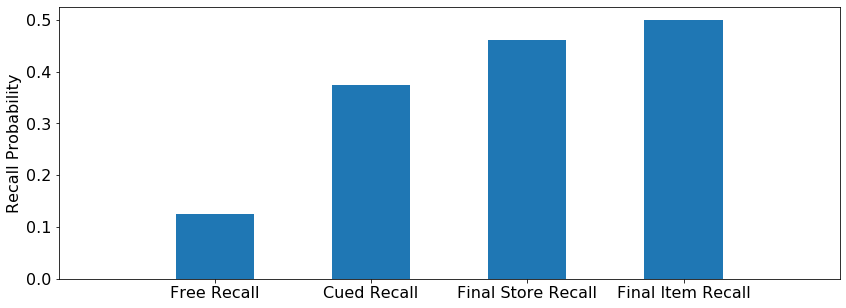

In [361]:
# import matplotlib.pyplot as plt
# import numpy as np

BAR_WIDTH = 0.5     # 0. < BAR_WIDTH <= 1.

def main():
    # the data you want to plot
    categories = ["Free Recall", "Cued Recall","Final Store Recall",'Final Item Recall']
    values     = [ mean_recalled,  mean_cued_recalled, correct_store_mean,correct_item_mean]
    # x-values for the center of each bar
    xs = np.arange(1, len(categories) + 1)
    # plot each bar centered
    fig, ax = plt.subplots(figsize=(14, 5))
    plt.bar(xs, values, width=BAR_WIDTH,align='center')
    # add bar labels
    plt.xticks(xs, categories,fontsize=16)
#     plt.xlabels(fontsize=18)
    plt.yticks(fontsize=16)
    plt.ylabel('Recall Probability',fontsize=16)
    # make sure the chart is centered
    plt.xlim(0, len(categories) + 1)
    # show the results
    plt.show()

main()

- Above recall probabilities were calculated while ignoring any subsequent key presses

# Intrusion Analysis

In [362]:
#FREE RECALL
# Correct Rejection : intrusion != 0 and keypress == True
# False Alarm: intrusion == 0 / recalled == 1 and keypress == True
# Miss : intrusion != 0 and keypress == False
# Hit: intrusion == 0 and keypress == False

#CUED RECALL                              #intra-list intrusion
# Correct Rejection : ( intrusion != 0 | (intrusion == 0 and recalled == 0) ) and keypress == True
# False Alarm: recalled == 1 and keypress == True
# Miss : ( intrusion != 0 | (intrusion == 0 and recalled == 0) ) and keypress == False
# Hit: intrusion == 0 and recalled == 1 and keypress == False

intrusion_df = pd.DataFrame(columns=["subject", "session", "trial", "type", "intrusion_type"])

rec_evs = full_evs.query('type == "REC_WORD"')
for i, row in rec_evs.iterrows():
    if row.intrusion != 0 and row.efr_mark == True:
        intrusion_type = "intrusions rejected"
    elif (row.intrusion == 0 or row.recalled == 1) and row.efr_mark == True:
        intrusion_type = "correct recalls rejected"
    elif row.intrusion != 0 and row.efr_mark != True:
        intrusion_type = "intrusions accepted"
    elif row.intrusion == 0 and row.efr_mark != True:
        intrusion_type = "correct recalls accepted"
    else:
        intrusion_type = "None"
    
    intrusion_df = intrusion_df.append({"subject":row.subject, 
                                        "session":row.session,
                                        "trial":row.trial,
                                        "type":"Free Recall",
                                        "intrusion_type":intrusion_type
                                       }, ignore_index=True)
    
cued_rec_evs = full_evs.query('type == "CUED_REC_WORD"')
for i, row in cued_rec_evs.iterrows():
    if row.recalled == 0 and row.efr_mark == True:
        intrusion_type = "intrusions rejected"
    elif row.recalled == 1 and row.efr_mark == True:
        intrusion_type = "correct recalls rejected"
    elif row.recalled == 0 and row.efr_mark == -999:
        intrusion_type = "intrusions accepted"
    elif row.recalled == 1 and row.efr_mark == -999:
        intrusion_type = "correct recalls accepted"
    else:
        intrusion_type = "None"
    
    intrusion_df = intrusion_df.append({"subject":row.subject, 
                                        "session":row.session,
                                        "trial":row.trial,
                                        "type":"Cued Recall",
                                        "intrusion_type":intrusion_type
                                       }, ignore_index=True)
    
ffr_rec_evs = full_evs.query('type == "FFR_REC_WORD"')
for i, row in ffr_rec_evs.iterrows():
    if row.intrusion < 0 and row.efr_mark == True:
        intrusion_type = "intrusions rejected"
    elif row.recalled == 1 and row.efr_mark == True:
        intrusion_type = "correct recalls rejected"
    elif row.intrusion < 0 and row.efr_mark != True:
        intrusion_type = "intrusions accepted"
    elif row.intrusion >= 0 and row.efr_mark != True:
        intrusion_type = "correct recalls accepted"
    else:
        intrusion_type = "None"
    
    intrusion_df = intrusion_df.append({"subject":row.subject, 
                                        "session":row.session,
                                        "trial":row.trial,
                                        "type":"Final Free Recall",
                                        "intrusion_type":intrusion_type
                                       }, ignore_index=True)

In [363]:
table = intrusion_df.groupby(["subject", "session", "trial", "type", "intrusion_type"]).size().reset_index(name='counts')

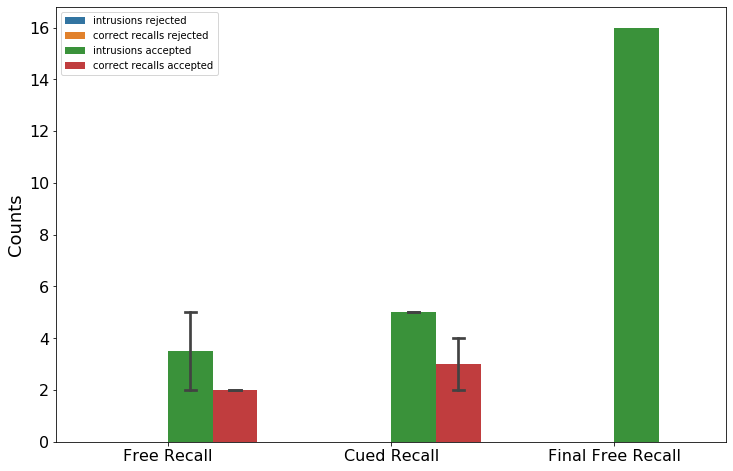

In [364]:
fig, ax = plt.subplots(figsize=(12,8))
p = sns.barplot(data=table, 
                x="type", 
                order=["Free Recall", "Cued Recall", "Final Free Recall"],
                y="counts", 
                hue="intrusion_type", 
                hue_order=["intrusions rejected", 
                           "correct recalls rejected", 
                           "intrusions accepted", 
                           "correct recalls accepted"],
#                 palette="crest",
                ci=68,
                capsize=0.05)
# plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("")
plt.ylabel("Counts", fontsize=18)
plt.gca().legend().set_title('')
# ax.yaxis.grid()
plt.show()

** Note that this is the sum over all delivery days

- Intrusions rejected: Intrusions that were correctly rejected
- Correct recalls rejected: Correct recalls that were incorrectly rejected
- Intrusions accepted: Correct recalls that were not rejected
- Correct recalls accepted: Intrusions that were not rejected

In [365]:
ci=None if len(full_evs.subject.unique()) < 5 else 68

# SPC

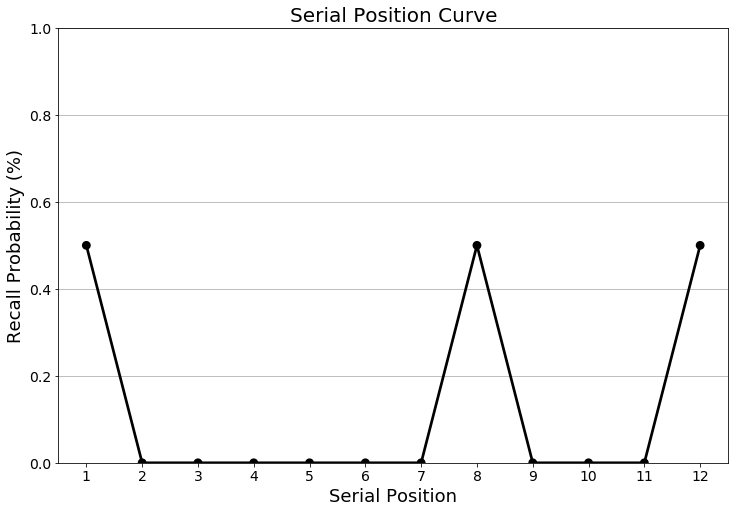

In [366]:
spc_df = full_evs.query("type=='WORD'").groupby(['subject', 'session', 'serialpos']) \
                                       .agg({'recalled':np.nanmean}).reset_index()

fig, ax = plt.subplots(figsize=(12, 8))
spc = sns.pointplot(data=spc_df, x='serialpos', y='recalled', ci=ci,
                    color='k', err_style='bars', capsize=.3, label="SPC")

plt.xlabel('Serial Position', fontsize=18)
plt.ylabel('Recall Probability (%)', fontsize=18); plt.ylim([0,1])
ax.yaxis.grid()
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title("Serial Position Curve", fontsize=20)
plt.show()

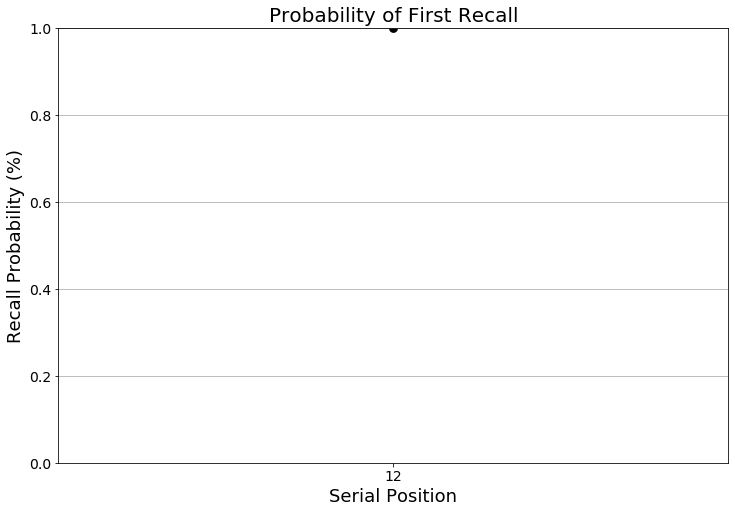

In [367]:
recword = full_evs.query('type=="REC_WORD"')
recword['pos'] = recword.groupby(['subject', 'session', 'trial']).cumcount()
first_recall_df = recword.query('pos == 0 and serialpos >= 0')
first_recall_df = first_recall_df.groupby(
    ['subject', 'session', 'serialpos']).agg(
    {'recalled': 'count'}).unstack(fill_value=0).stack().reset_index()
first_recall_df['n_lists'] = first_recall_df.groupby(['subject'])['recalled'].transform('sum')
first_recall_df['prob'] = first_recall_df['recalled'] / first_recall_df['n_lists']

fig, ax = plt.subplots(figsize=(12, 8))
pfr = sns.pointplot(data=first_recall_df, x='serialpos', y='prob', ci=ci,
                    color='k', err_style='bars', capsize=.1)
plt.xlabel('Serial Position', fontsize=18)
plt.ylabel('Recall Probability (%)', fontsize=18); plt.ylim([0,1])
ax.yaxis.grid()
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title("Probability of First Recall", fontsize=20)
plt.show()

# Lag-CRP

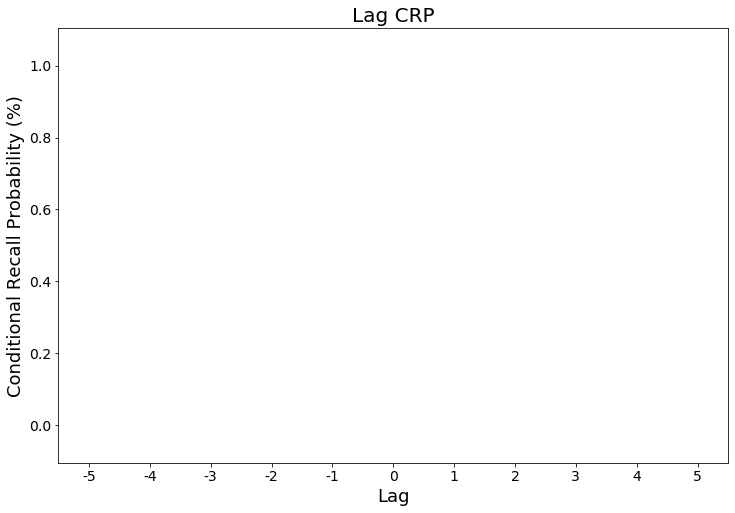

In [368]:
full_evs['itemno'] = full_evs['item'].astype('category').cat.codes
crp_df = full_evs.groupby(['subject']).apply(
    pb.pd_crp,
    itemno_column='itemno',
    list_index=['subject', 'session', 'trial'],
    lag_num=5).reset_index()

fig, ax = plt.subplots(figsize=(12,8))
crp = sns.pointplot(data=crp_df, x='lag', y='prob', ci=ci,
                    color='k', err_style='bars', capsize=.2)
plt.title("Lag CRP", fontsize=20)
plt.xlabel("Lag", fontsize=18)
plt.ylabel("Conditional Recall Probability (%)", fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
# plt.grid()
# p.yaxis.grid()
plt.show()

# Spatial CRP

In [369]:
# def isolate_storeX(row):
#     store_location = eval(row['store position'])
#     return store_location[0]

# def isolate_storeZ(row):
#     store_location = eval(row['store position'])
#     return store_location[2]

# def isolate_playerX(row):
#     player_position = eval(row['player position'])
#     return player_position[0]

# def isolate_playerZ(row):
#     player_position = eval(row['player position'])
#     return player_position[2]

# full_evs.loc[full_evs["type"] == "WORD", "storeX"] = full_evs.loc[full_evs["type"] == "WORD"].apply(isolate_storeX, axis=1)
# full_evs.loc[full_evs["type"] == "WORD", "storeZ"] = full_evs.loc[full_evs["type"] == "WORD"].apply(isolate_storeZ, axis=1)
# full_evs.loc[full_evs["type"] == "WORD", "presX"] = full_evs.loc[full_evs["type"] == "WORD"].apply(isolate_playerX, axis=1)
# full_evs.loc[full_evs["type"] == "WORD", "presZ"] = full_evs.loc[full_evs["type"] == "WORD"].apply(isolate_playerZ, axis=1)

In [370]:
def get_new_item_id(item, wordpool=[]):
    if item not in wordpool:
        return -999
    return wordpool.index(item)

# need to redo itemno because not using all items in wordpool
word_evs = full_evs.query('type == "WORD" and itemno > -1')
wordpool_subset = word_evs.item.unique().tolist()
full_evs['itemno'] = full_evs['item'].transform(get_new_item_id, wordpool=wordpool_subset)

In [371]:
word_evs = full_evs.query('type == "WORD"')
#word_evs = full_evs.query('itemno != -999 and type == "WORD"')
store_items = word_evs[['store', 'item', 'itemno']].drop_duplicates()
sub_store_locs = word_evs[['store', "storeX", "storeZ", 'subject']].drop_duplicates()
sub_store_locs['type'] = 'WORD_VALS'
loc_evs = sub_store_locs.merge(store_items)
# loc_evs = loc_evs.sort_values('itemno')
test_evs = full_evs.append(loc_evs)

In [372]:
bins = [12.96160383, 41.99123618, 61.53639199, 77.73374529, 97.11224258]

spatial_crp = test_evs.groupby('subject').apply(
    pb.pd_sem_crp, list_index=['subject', 'session', 'trial'], 
    sim_columns=['storeX', 'storeZ'], bins=bins, ret_counts=False).reset_index()

In [374]:
# fig = plt.figure(figsize = (12,8))
# fig.patch.set_facecolor('white')
# ax1 = sns.pointplot(data=spatial_crp, x='sem_bin', y='prob', marker = 'o', color = 'black', capsize=0.1, ci=ci)
# ax1.set_xlabel('Distance bin', fontsize=18)
# ax1.set_xticklabels(["very near", "near", "intermediate", "far", "very far"], fontsize=14)
# ax1.set_ylabel('Conditional response probability (%)', fontsize=18)
# plt.yticks(fontsize=14)
# ax1.yaxis.grid()
# plt.tick_params(labelsize=16)
# plt.ylim(0)
# plt.title("Spatial CRP", fontsize=20)
# plt.show()

# Navigation Trajectory

In [375]:
# import random
# import os
# import matplotlib.pyplot as plt
# from matplotlib.collections import LineCollection


# for i, row in deliv_table.iterrows():

#     print("{} session {}".format(row.subject, row.session))
#     # pull up jsonl file from data2 directory
#     file_name = "{}/session_{}/session.jsonl".format(row.subject, row.session)
#     file_dir = os.path.join(data_dir, file_name)

#     new_file = []
#     for line in open(file_dir, "r"):
#         # replace this specific entry to empty string
#         if '"point condition":SerialPosition,' in line:
#             line = line.replace('"point condition":SerialPosition,', '')
#         elif '"point condition":SpatialPosition,' in line:
#             line = line.replace('"point condition":SpatialPosition,', '')
#         elif '"point condition":Random,' in line:
#             line = line.replace('"point condition":Random,', '')

#         data_dict = json.loads(line)
#         new_file.append(data_dict)

#     with open("session_tmp.jsonl", "w") as outfile:
#         for line in new_file:
#             json.dump(line, outfile)
#             outfile.write('\n')

#     log = pd.read_json("session_tmp.jsonl", lines=True)
#     log = log[(log.type=='PlayerTransform')|(log.type=='object presentation begins')]

#     def extract_position(row):
#         if row.type=='PlayerTransform':
#             return (row['data']['positionX'], row['data']['positionY'], row['data']['positionZ'])
#         elif row.type=='object presentation begins':
#             return eval(row['data']['player position'])
#         else:
#             return np.nan

#     log['location']=log.apply(extract_position, axis=1)
#     log['trial']=log.apply(lambda row: row['data']['trial number'] if np.isin('trial number', list(row['data'].keys())) else np.nan, axis=1)
#     movements = log.fillna(method='pad').dropna()
#     sess_pos = np.stack(list(map(list, movements.location.values)))

#     group_mov = movements.groupby('trial')    
#     dd_list = np.array(list(group_mov.groups.keys())).astype(int)
#     pos_by_list = [np.stack(list(map(list, group_mov.get_group(i)['location']))) for i in dd_list]

#     fig, ax = plt.subplots(len(dd_list)//2 + len(dd_list)%2, 2, 
#                            figsize= (20, 8*(len(dd_list)//2 + len(dd_list)%2)) )
#     ax = ax.ravel()


#     for i, dd in enumerate(dd_list):
#         store_locs = log['data'][(log.type=='object presentation begins')&(log.trial==i)].apply(lambda json: eval(json['store position']))
#         store_names = log['data'][(log.type=='object presentation begins')&(log.trial==i)].apply(lambda json: json['store name'])
#         list_stores = np.stack(list(map(list, store_locs.values)))


#         points = np.array([pos_by_list[i][:, 0], pos_by_list[i][:, 2]]).T.reshape(-1, 1, 2)
#         segments = np.concatenate([points[:-1], points[1:]], axis=1)

#         # don't count motionless time
#         segments = segments[1:][np.any(np.diff(segments, axis=0)!=0, axis=(1, 2))]
#         lc = LineCollection(segments, cmap='copper_r')
#         # Set the values used for colormapping
#         lc.set_array(np.linspace(0, 1, len(segments)))
#         lc.set_linewidth(3); lc.set_alpha(.6)
#         line = ax[i].add_collection(lc)
#         ax[i].scatter(list_stores[:, 0], list_stores[:, 2])
#         texts = []
#         for x, y, name, order in zip(list_stores[:, 0], list_stores[:, 2], store_names, np.arange(len(store_names))):
#             texts.append(ax[i].text(x-10, y+5, name.capitalize() + ' ({})'.format(order)))
#         ax[i].set_title('Delivery Day %d' %(dd+1), fontsize=20)
#         ax[i].set_xticklabels([]);ax[i].set_yticklabels([])
#     #         adjust_text(texts, expand_text=(1.2, 1.2))


#         positions = []
#         tmp_texts = []
#         for text in texts:
#     #             print(text.get_position())
#             positions.append(text.get_position())
#             tmp_texts.append(text)

#         point1_1 = (26.700000000000003, 64.1)
#         if point1_1 in positions:
#             text1 = tmp_texts[positions.index(point1_1)]
#             text1.set_visible(False)
#             ax[i].text(26.7, 54.1, text1.get_text())

#         if ((25.1, 31.7) in positions) and ((48.3, 32.9) in positions):
#             text1 = tmp_texts[positions.index((25.1, 31.7))]
#             text2 = tmp_texts[positions.index((48.3, 32.9))]

#             text1.set_visible(False); text2.set_visible(False)

#             ax[i].text(15.1, 31.7, text1.get_text())
#             ax[i].text(52.3, 32.9, text2.get_text())

#         point3_1 = (4.5, -28.700000000000003); point3_2 = (25.4, -28.1); point3_3 = (52.3, -28.5)
#         if (point3_1 in positions) and (point3_2 in positions):

#             if point3_3 in positions:
#                 text1 = tmp_texts[positions.index(point3_1)]
#                 text2 = tmp_texts[positions.index(point3_2)]
#                 text3 = tmp_texts[positions.index(point3_3)]

#                 text1.set_visible(False); text2.set_visible(False); text3.set_visible(False)

#                 ax[i].text(-10, -28.700000000000003, text1.get_text())
#                 ax[i].text(20.4, -28.1, text2.get_text())
#                 ax[i].text(61.3, -28.5, text3.get_text())
#             else:
#                 text1 = tmp_texts[positions.index(point3_1)]
#                 text2 = tmp_texts[positions.index(point3_2)]

#                 text1.set_visible(False); text2.set_visible(False)

#                 ax[i].text(-7, -28.700000000000003, text1.get_text())
#                 ax[i].text(25.4, -28.1, text2.get_text())

#         elif (point3_2 in positions) and (point3_3 in positions):
#             text1 = tmp_texts[positions.index(point3_2)]

#             text1.set_visible(False)

#             ax[i].text(10.4, -28.1, text1.get_text())

#         point4_1 = (-13.1, -53.5); point4_2 = (4.6, -53.8); point4_3 = (22.200000000000003, -55.9)
#         if (point4_1 in positions) and (point4_2 in positions):

#             if point4_3 in positions:
#                 text1 = tmp_texts[positions.index(point4_1)]
#                 text2 = tmp_texts[positions.index(point4_2)]
#                 text3 = tmp_texts[positions.index(point4_3)]

#                 text1.set_visible(False); text2.set_visible(False); text3.set_visible(False)

#                 ax[i].text(-20, -65.5, text1.get_text())
#                 ax[i].text(0, -53.8, text2.get_text())
#                 ax[i].text(30, -55.9, text3.get_text())
#             else:
#                 text1 = tmp_texts[positions.index(point4_1)]
#                 text2 = tmp_texts[positions.index(point4_2)]

#                 text1.set_visible(False); text2.set_visible(False)

#                 ax[i].text(-20, -53.5, text1.get_text())
#                 ax[i].text(5, -53.8, text2.get_text())

#         elif (point4_2 in positions) and (point4_3 in positions):
#             text1 = tmp_texts[positions.index(point3_2)]

#             text1.set_visible(False)

#             ax[i].text(0, -53.8, text1.get_text())


#     fig.subplots_adjust(hspace=0.2, wspace=0.2)
#     plt.tight_layout()
#     cbar = fig.colorbar(line, ax=ax[:], location='right', shrink = 0.7)
#     cbar.ax.tick_params(labelsize=16)
#     cbar.ax.set_yticklabels(["Start", "", "", "", "", "End"])
#     fig.set_facecolor('white')
#     for a in ax:
#         a.axis("off")
#     plt.show()

In [376]:
# for session in full_evs['session'].unique():
#     print('Session %d' %session)
#     log = pd.read_json('/data/eeg/{}/behavioral/EFRCourierReadOnly/session_{}/session.jsonl'.format(sub_df_subject, sub_df_session), lines=True)
#     log = log[(log.type=='PlayerTransform')|(log.type=='object presentation begins')]

#     def extract_position(row):
#         if row.type=='PlayerTransform':
#             return (row['data']['positionX'], row['data']['positionY'], row['data']['positionZ'])
#         elif row.type=='object presentation begins':
#             return eval(row['data']['player position'])
#         else:
#             return np.nan

#     log['location']=log.apply(extract_position, axis=1)
#     log['trial']=log.apply(lambda row: row['data']['trial number'] if np.isin('trial number', list(row['data'].keys())) else np.nan, axis=1)
#     movements = log.fillna(method='pad').dropna()
#     sess_pos = np.stack(list(map(list, movements.location.values)))
    
#     group_mov = movements.groupby('trial')
#     dd_list = np.array(list(group_mov.groups.keys())).astype(int)
#     pos_by_list = [np.stack(list(map(list, group_mov.get_group(i)['location']))) for i in dd_list]
#     fig, ax = plt.subplots(len(dd_list)//2+len(dd_list)%2, 2, figsize=(12, 5*(len(dd_list)//2+len(dd_list)%2)))
#     ax = ax.ravel()
#     for i, dd in enumerate(dd_list):
#         store_locs = log['data'][(log.type=='object presentation begins')&(log.trial==i)].apply(lambda json: eval(json['store position']))
#         store_names = log['data'][(log.type=='object presentation begins')&(log.trial==i)].apply(lambda json: json['store name'])
#         list_stores = np.stack(list(map(list, store_locs.values)))

#         points = np.array([pos_by_list[i][:, 0], pos_by_list[i][:, 2]]).T.reshape(-1, 1, 2)
#         segments = np.concatenate([points[:-1], points[1:]], axis=1)
#         lc = LineCollection(segments, cmap='hot')
#         # Set the values used for colormapping
#         lc.set_array(np.linspace(0, 1, len(segments)))
#         lc.set_linewidth(3); lc.set_alpha(.6)
#         line = ax[i].add_collection(lc)
#         ax[i].scatter(list_stores[:, 0], list_stores[:, 2])
#         texts = []
#         for x, y, name, order in zip(list_stores[:, 0], list_stores[:, 2], store_names, np.arange(len(store_names))):
#             texts.append(ax[i].text(x-5, y+5, name.capitalize() + ' ({})'.format(order)))
#         adjust_text(texts)
#         ax[i].set_title('DD %d' %dd, fontsize=14)
#         ax[i].set_xticklabels([]);ax[i].set_yticklabels([])
#     plt.tight_layout()
#     cbar = fig.colorbar(line, ax=ax[:], location='right', shrink = 0.5)
#     cbar.set_label('% of path')
#     fig.set_facecolor('white')
#     plt.show()

In [ ]:
# jupyter nbconvert --execute --to html EFRCourier_behavioral_analysis_clean.ipynb --no-input

# iEEG

In [378]:
# evs=evs.drop(columns=['stim_params'])# otherwise ptsa won't work
reader = cml.CMLReader(subject=sub_df_subject, experiment=sub_df_exp, session=sub_df_session,montage=sub_df.iloc[0]['montage'],localization=sub_df.iloc[0]['localization'])
word_evs = evs[evs.type=='WORD']
# evs=evs.drop['stim_params']
pairs = reader.load('pairs')
pairs
buf = 2000
eeg= reader.load_eeg(word_evs, rel_start=-500 - buf, rel_stop=500 + buf, scheme=pairs)#.to_ptsa()
eeg_ptsa = eeg.to_ptsa()


In [379]:
encoding_evs = evs[evs['phase']=='encoding']
# encoding_evs


In [380]:
# # Stim during encoding:
# Estim=pd.DataFrame([]);
# Enostim=pd.DataFrame([])


# encoding_evs = evs[evs['phase']=='encoding']
# stim_words=[]; nonstim_words=[]
# for indx in range(len(encoding_evs)):
#     if indx > 0:
#         if encoding_evs.iloc[indx]['type']=='WORD' and encoding_evs.iloc[indx-1]['type']=='STIM':
#             stim_words.append(encoding_evs.iloc[indx]['item'])
#         elif encoding_evs.iloc[indx]['type']=='WORD' and encoding_evs.iloc[indx-1]['type']=='pointing finished':
#             nonstim_words.append(encoding_evs.iloc[indx]['item'])
#     elif indx == 0: # account for first item in list
#             if encoding_evs.iloc[indx]['type']=='WORD':
#                 nonstim_words.append(encoding_evs.iloc[indx]['item'])

# #     assert(len(stim_words)  + len(nonstim_words))==27 ,f'Error in words number: subject {ret_stim_subject} session {ret_stim_session} list {ret_stim_list}'      
# Estim=Estim.append(encoding_evs[encoding_evs['item'].isin(stim_words)])
# Enostim=Enostim.append(encoding_evs[encoding_evs['item'].isin(nonstim_words)])
# # print(len(Estim))
# # print(len(Enostim))



In [381]:

# filter_line_noise = True # filter 60 and 120 hz

# # word_evs = evs[evs.type=='WORD']
# events=[Estim,Enostim]
# events_title=['Stim Words','No-Stim Words']


# buf = 2000
# eeg_ptsa = reader.load_eeg(Estim, rel_start=-500 - buf, rel_stop=500 + buf, scheme=pairs).to_ptsa()

# # Butterworth filter to remove 60 Hz line noise + harmonic at 120
# if filter_line_noise == True:
#     eeg_ptsa = eeg_ptsa.filtered([58, 62])
#     eeg_ptsa = eeg_ptsa.filtered([118, 122])

# plt.figure(figsize=(10, 7))
# eeg_raw = eeg_ptsa.mean(dim=['event','channel'])#.plot()
# e=eeg_raw.plot(label = "Stim words",color='grey')

# #3 plot charachteristics
# plt.xlabel('Time from word onset(ms)', fontsize=18)
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)
# plt.axvline(x=0,color='black',linewidth=2)
# plt.axvline(x=1600,color='black',linewidth=2)
# # add rectangle
# hight=abs(int(min(eeg_raw)))+int(max(eeg_raw))
# rect = plt.Rectangle((-1000,int(min(eeg_raw))),3000,hight,linewidth=1.5,fill=True,alpha=0.6,facecolor='lightgrey', edgecolor='lightgrey',linestyle='-')
# plt.text(1600, int(min(eeg_raw)), 'Word offset', fontsize = 18)
# # Add the patch to the Axes
# plt.gca().add_patch(rect)


# # Plot no-stim data
# eeg_ptsa = reader.load_eeg(Enostim, rel_start=-500 - buf, rel_stop=500 + buf, scheme=pairs).to_ptsa()

# # Butterworth filter to remove 60 Hz line noise + harmonic at 120
# if filter_line_noise == True:
#     eeg_ptsa = eeg_ptsa.filtered([58, 62])
#     eeg_ptsa = eeg_ptsa.filtered([118, 122])

# eeg_raw = eeg_ptsa.mean(dim=['event','channel'])#.plot()
# e=eeg_raw.plot(label = "No-stim words",color='red')
# plt.legend(loc="upper left",fontsize=18)
# e=plt.xlabel('Time from word onset (ms)', fontsize=18)
# plt.title('Encoding', fontsize=20)


# Single trial by channel

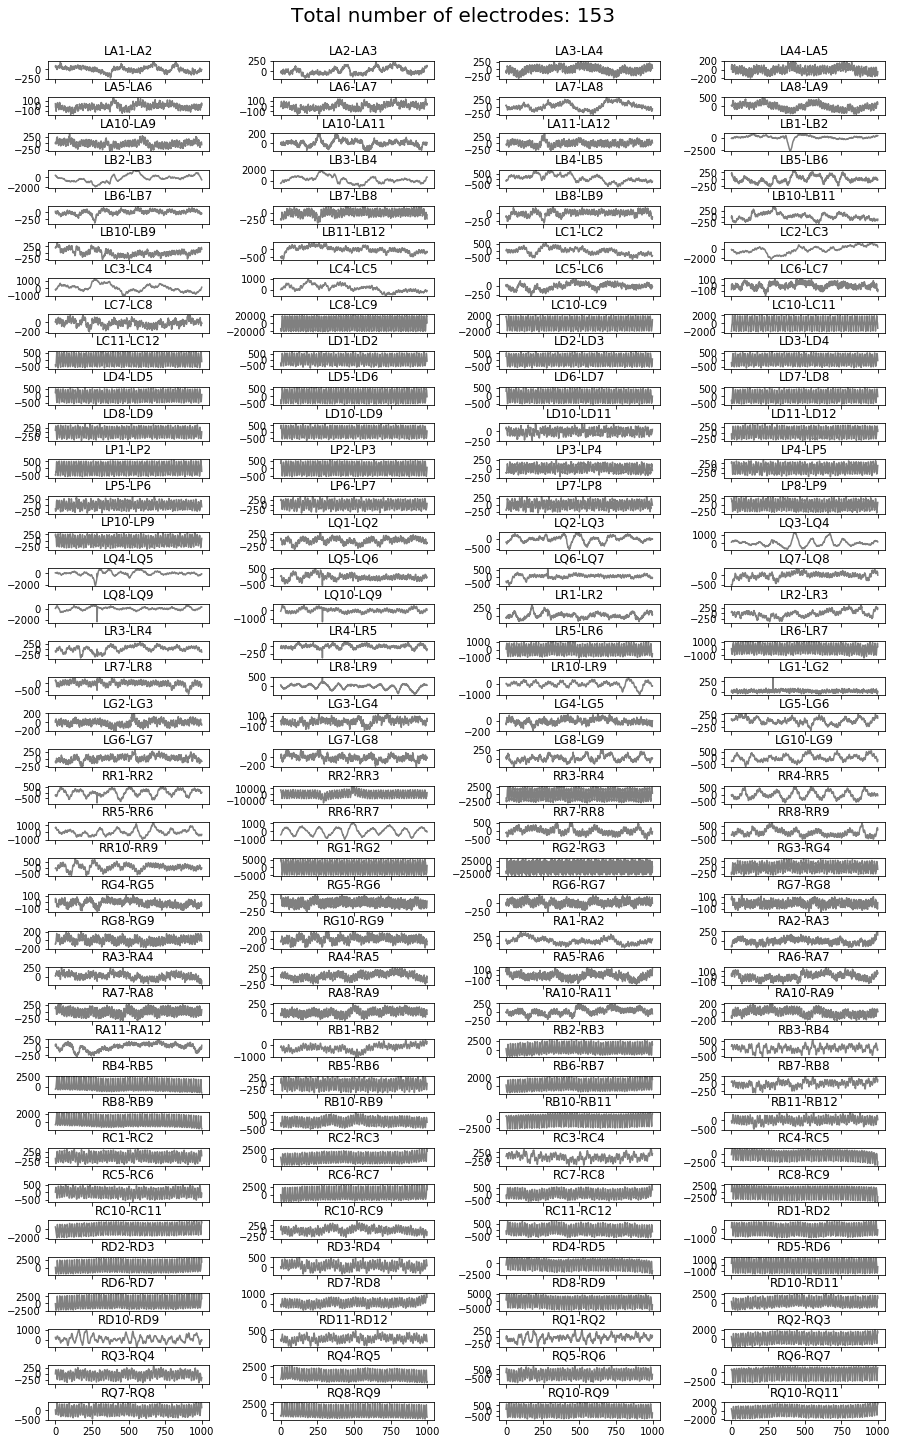

In [382]:
filter_line_noise = False # filter 60 and 120 hz
event_number_to_plot = 5  # which event to plot data? Maybe don't select 0 since first one could be weird

no_stim_evs = evs[evs.type=='pointing finished']
# rec_evs = evs[evs.type=='REC_WORD']
pairs = reader.load('pairs')

#     pairs = reader.load('pairs')
buf = 500
eeg = reader.load_eeg(no_stim_evs, rel_start= -buf , rel_stop = 1000 + buf, scheme=pairs)
eeg_ptsa = eeg.to_ptsa()[event_number_to_plot]

# Butterworth filter to remove 60 Hz line noise + harmonic at 120
if filter_line_noise == True:
    eeg_ptsa = eeg_ptsa.filtered([58, 62])
    eeg_ptsa = eeg_ptsa.filtered([118, 122])

fig, ax = plt.subplots(len(pairs)//4, 4, figsize=(15, 25), sharex=True, sharey=False)
ax = np.ravel(ax)
for i in range(len(pairs) - len(pairs)%4):
    ax[i].plot(eeg_ptsa[i, :1000],color='grey')
    ax[i].set_title(pairs['label'].iloc[i])
    if i ==len(pairs) - len(pairs)%4:
        ax[i].set_xlabel('Time (ms)')
    
plt.subplots_adjust(wspace=.4, hspace=1)
# plt.suptitle(sub_df_subject+', session '+str(sub_df_session), fontsize=20,y=0.91)
_=plt.suptitle('Total number of electrodes: '+ str(len(pairs)), fontsize=20,y=0.91)

# plt.plot()

# print('Number of electrodes: ', len(pairs))

Raw iEEG data (1 Sec) in each collected channel for one example trial.

# SME

CPP total time wavelet loop:  1.6415297985076904


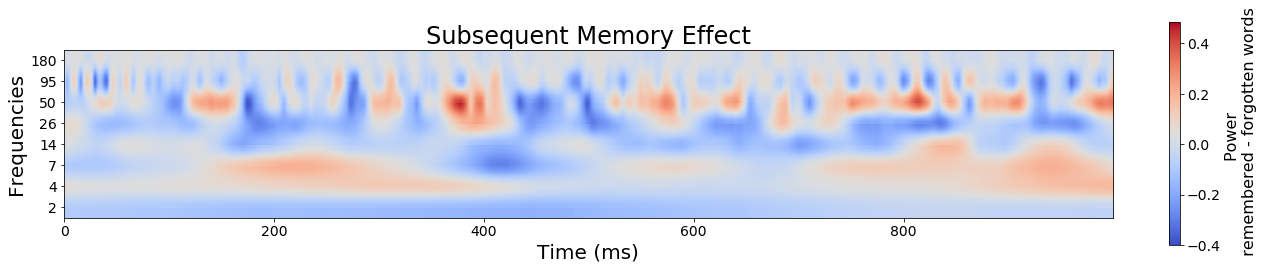

In [383]:
from ptsa.data.filters import MorletWaveletFilter

word_evs = evs[evs.type=='WORD']
contacts = reader.load('contacts')

buf = 500
eeg = reader.load_eeg(word_evs, rel_start=-500 - buf, rel_stop=500 + buf, scheme=contacts)
sr = round(eeg.samplerate)
eeg_ptsa = eeg.to_ptsa()

# Butterworth filter to remove 60 Hz line noise + harmonic at 120
eeg_ptsa = eeg_ptsa.filtered([58, 62])
eeg_ptsa = eeg_ptsa.filtered([118, 122])

#Get spectral power
myfreqs = np.logspace(np.log10(2), np.log10(180), 8)  #4-100 Hz, 40 frequencies
wf = MorletWaveletFilter(timeseries=eeg_ptsa, freqs=myfreqs, width=4, output='power') 
pow_wavelet = wf.filter()   #output is freqs, events, elecs, and time
buff_in_samples=int((buf/1000.)*sr) # convert buffer time to samples
pows = pow_wavelet.isel(time=np.arange(buff_in_samples,len(pow_wavelet.time)-buff_in_samples))  #remove buffer period    
pows = np.log10(pows) # get log of powers. # powes time is 2750 samples, corresponding to 2750/500=5,500ms. # in some versions use:np.log10(pows.data) instead.

mask = word_evs.recalled.astype(bool).values
sme = pows[:, mask].mean(['event', 'channel']) - pows[:, ~mask].mean(['event', 'channel'])

# PLOT
fig = plt.figure(figsize=(20, 10))
ax = plt.gca()
im = ax.imshow(sme, cmap='coolwarm', aspect = 20, interpolation='hamming')
plt.yticks(ticks = range(0, 8), labels=[f"{f:.0f}" for f in np.logspace(np.log10(2), np.log10(180), 8)])
labels = ax.get_xticklabels()
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
plt.xlabel('Time (ms)', fontsize=20)
plt.ylabel('Frequencies', fontsize=20)
plt.title('Subsequent Memory Effect', fontsize=24)
cbar = plt.colorbar(im, ax=ax, fraction = .01)
cbar.set_label(label='Power \n remembered - forgotten words', size=16)
cbar.ax.tick_params(labelsize=14)
plt.gca().invert_yaxis()
plt.show()